In [1]:
# import matplotlib.pyplot as plot
# import numpy as np
# import gudhi

# # rips_on_tore3D_1307.pers obtained from write_persistence_diagram method
# persistence_file='/home/bazyli/gitworkspace/gitBKrp/persistence/pcodebooks/rawdata/exp01_synthetic/pd_gauss_0_1/Circle/11.h5.pc.simba.1.00001_3.persistence'
# a=gudhi.plot_persistence_diagram(persistence_file=persistence_file,
#     legend=True)
    
# arr = gudhi.read_persistence_intervals_in_dimension(persistence_file, only_this_dim=1)
# plot.show()

# Matlab data loading and processing

In [2]:
import numpy as np
import scipy.io
from gudhi.representations.preprocessing import BirthPersistenceTransform, DiagramScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from preprocessing import *
from persistent_bow import *
from visualization import *

In [3]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

In [4]:
data.shape # Here are 50 diagrams (rows), 7 types(cols) = 350 diagrams

(50, 7)

In [5]:
data[0][1].shape # each diagram has n rows and 2 colums # here we get first diagram from type "1"

(23, 2)

In [6]:
# y - labels - type of diagram [0-7]
# We transpose to iterate over diagram list
y = []
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
y = np.array(y)

# data.T = 2d array of diagrams as row, column as type
X = data.T.reshape(-1)

In [7]:
preprocessing_pipeline = Pipeline([
    ("name1", BirthPersistenceTransform()),
    ("name2", DiagramScaler(
        use=True,
        scalers=[
            ((0,), MaxAbsScaler(copy=False)),
            ((1,), MaxAbsScaler(copy=False))
        ]
    )),
])

preprocessed = np.array(preprocessing_pipeline.fit_transform(X))

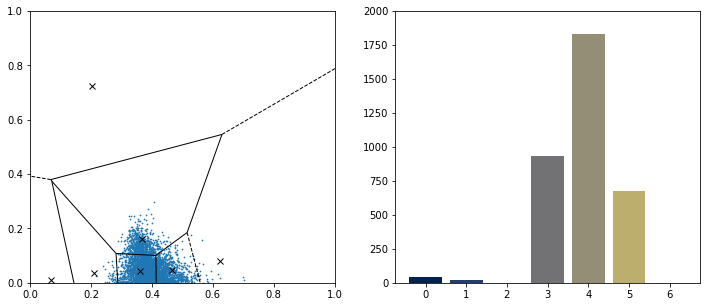

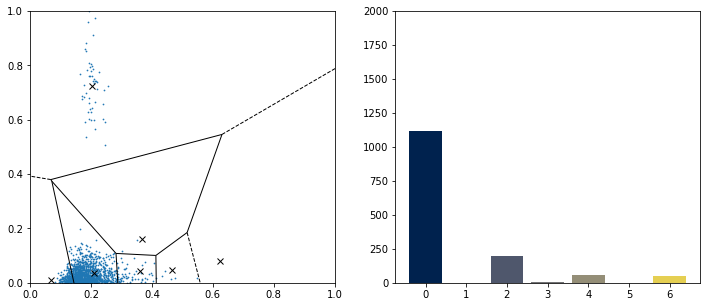

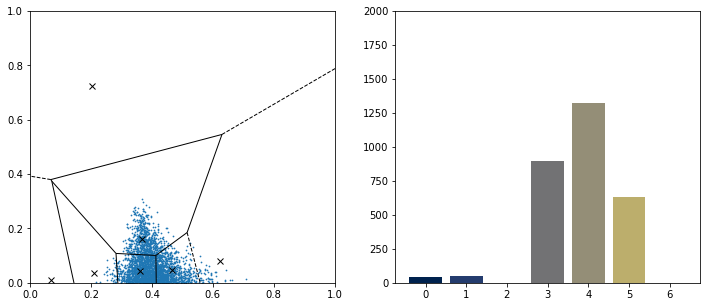

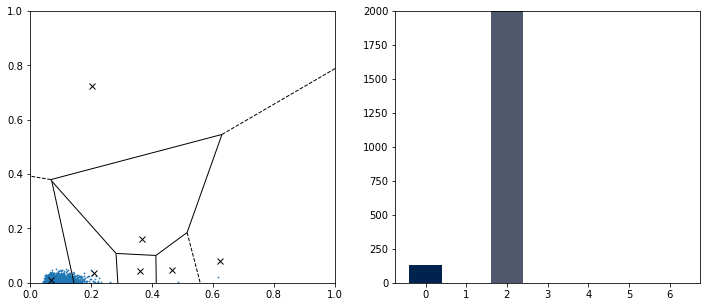

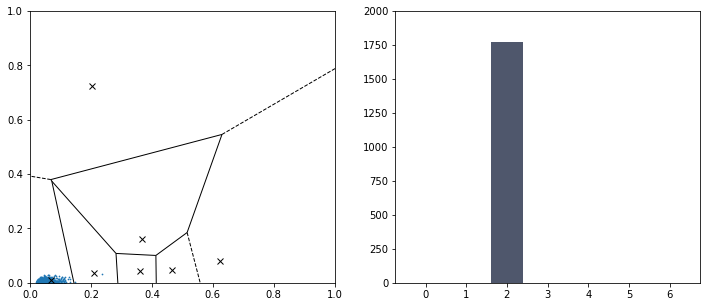

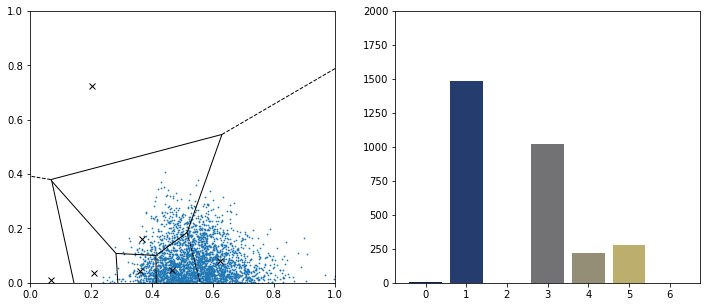

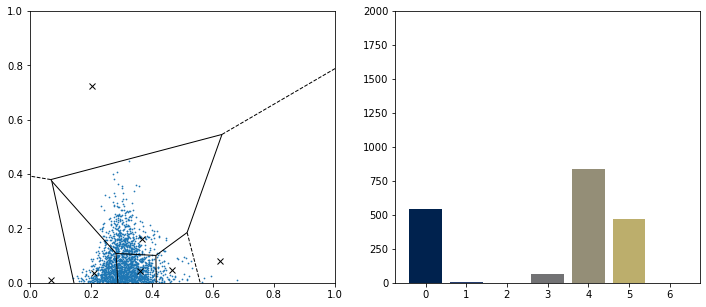

In [11]:
#Classes visualization
vectorizer = PersistentBow(KMeans(7))
vectorizer.fit(preprocessed)

for label in np.unique(y):    
    class_X = preprocessed[y==label]
    joined_X = np.concatenate(class_X)
    bow = vectorizer.transform([joined_X])[0]
    
    plt.figure(figsize=(12,5))
    ax = plt.subplot(121)
    plot_voronoi(vectorizer.cluster, ax=ax)
    ax.scatter(joined_X[:, 0], joined_X[:, 1], s=0.5)
    ax = plt.subplot(122)
    plot_bow(bow, 2000, ax=ax)

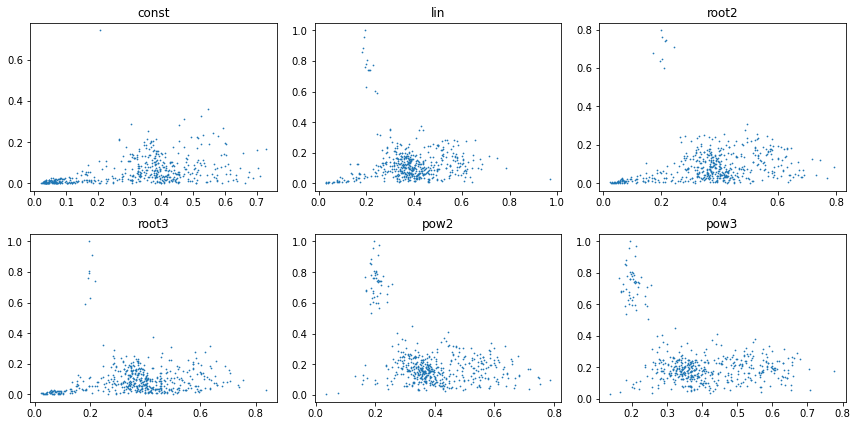

In [17]:
#Different persistence weighting functions visualization
sampling_weights = {
    "const":None,
    "lin" : lambda x : x,
    "root2" : lambda x : x**(1/2),
    "root3" : lambda x : x**(1/2),
    "pow2" : lambda x : x**2,
    "pow3" : lambda x : x**3,
}

index = 1
plt.figure(figsize=(12,6))

for name, weight in sampling_weights.items():
    transformed = RandomPDSampler(500, weight).fit_transform(preprocessed, y)[0]
    
    ax = plt.subplot(2,3,index)
    ax.set_title(name)
    ax.scatter(transformed[:, 0], transformed[:, 1], s=0.5)
    
    index += 1
    
plt.tight_layout(pad=1.0)

### Wstepne proby uczenia

In [155]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics.pairwise import pairwise_kernels
import sklearn
import gudhi
from gudhi.representations.kernel_methods import SlicedWassersteinKernel

In [179]:
pbow_pipeline = Pipeline([
    ("name1", BirthPersistenceTransform()),
    ("name2", DiagramScaler(
        use=True,
        scalers=[
            ((0,), MaxAbsScaler(copy=False)),
            ((1,), MaxAbsScaler(copy=False))
        ]
    )),
    ("name3", PersistentBow(KMeans(7), RandomPDSampler(2500)))
])


models_to_test = {
    "PBoW" : pbow_pipeline,
    "SWK": SlicedWassersteinKernel(num_directions=10, bandwidth=1.),
    "Bottleneck" : gudhi.representations.metrics.BottleneckDistance(0.0001)
}

#Fast hack to make it scikit-compliant
setattr(SlicedWassersteinKernel, "get_params",
        lambda self, deep: {
            "bandwidth":self.bandwidth,
            "num_directions" : self.sw_.num_directions
        })


In [180]:
for name, model in models_to_test.items():
    final_pipeline = Pipeline([
        ("Model", model),
        ("Predictor", SVC())
    ])
    
    results = cross_validate(final_pipeline, X, y, cv=5)
    print(name)
    print(pd.DataFrame(results))

PBoW
   fit_time  score_time  test_score
0  0.503691    0.046971    0.957143
1  0.418994    0.141927    0.957143
2  0.443732    0.045974    0.885714
3  0.655592    0.067956    0.900000
4  0.515681    0.048972    0.885714
SWK
    fit_time  score_time  test_score
0   4.510982    2.315451    0.985714
1   4.351744    2.945999    0.957143
2  12.466928    5.730750    0.971429
3  11.753013    5.773172    0.942857
4  11.537260    5.650111    0.957143
Bottleneck
    fit_time  score_time  test_score
0  49.263583   15.519059    0.871429
1  31.874990   17.539129    0.914286
2  32.912660   14.757379    0.842857
3  30.635879   15.490042    0.900000
4  30.390163   14.880461    0.871429


In [190]:
class MyScaler():
    def __init__(self, copy=True):
        pass
    def fit(self,X,y=None):
        self.max = np.max(X)
    def transform(self,X):
        return X / self.max

In [199]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler
diagrams=[np.array([[0.5,6.],[3.,10.],[5.,4.]]), np.array([[1.,20.],[2.,40.],[3.,60.]])]

In [200]:
for scaler in [MinMaxScaler, MyScaler, MaxAbsScaler]:
    scalers = [((0,), scaler(copy=False)), ((1,), scaler(copy=False))]
    ds = DiagramScaler(use=True, scalers=scalers)
    ds.fit(diagrams)
    out = ds.transform(diagrams)
    print(f'{scaler}\n',out[0],'\n\n', out[1],'\n')
    print('test:= ', ds.transform([np.array([[0., 2.]])]), '\n')

<class 'sklearn.preprocessing._data.MinMaxScaler'>
 [[0.         0.03571429]
 [0.55555556 0.10714286]
 [1.         0.        ]] 

 [[0.11111111 0.28571429]
 [0.33333333 0.64285714]
 [0.55555556 1.        ]] 

test:=  [array([[-0.11111111, -0.03571429]])] 

<class '__main__.MyScaler'>
 [[0.1        0.1       ]
 [0.6        0.16666667]
 [1.         0.06666667]] 

 [[0.2        0.33333333]
 [0.4        0.66666667]
 [0.6        1.        ]] 

test:=  [array([[0.        , 0.03333333]])] 

<class 'sklearn.preprocessing._data.MaxAbsScaler'>
 [[0.1        0.1       ]
 [0.6        0.16666667]
 [1.         0.06666667]] 

 [[0.2        0.33333333]
 [0.4        0.66666667]
 [0.6        1.        ]] 

test:=  [array([[0.        , 0.03333333]])] 



In [ ]:
# Tylko MinMaxScaler da nam ujemne wartości
# MaxAbs scaler zachowuje tak jak ten MyScaler wiec najlepiej bedzie mozna go dac
# Do zapytania ktore uzyc

In [ ]:
# Dziala ok mozna dodac do pipeline:
#TODO: dodac do pipeline [0,1] x [0,1] scaler
# DiagramScaler(
#         use=True,
#         scalers=[
#             ((0,), MinMaxScaler(copy=False)),
#             ((1,), MinMaxScaler(copy=False))
#         ]
#      )